In [14]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import LinearOperator

from jlinops import _CustomLinearOperator, get_device, get_module, device_to_module

import jlinops

In [3]:
def block_matrix_operator(A1, A2, A3, A4):
    # Check dimensions for compatibility
    if A1.shape[1] != A3.shape[1] or A2.shape[1] != A4.shape[1] or A1.shape[0] != A2.shape[0] or A3.shape[0] != A4.shape[0]:
        raise ValueError("Block matrices are not compatible")

    # Define the matvec function
    def matvec(x):
        mid = A1.shape[1]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.matvec(x1) + A2.matvec(x2), A3.matvec(x1) + A4.matvec(x2)])

    # Define the rmatvec function
    def rmatvec(x):
        mid = A1.shape[0]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.rmatvec(x1) + A3.rmatvec(x2), A2.rmatvec(x1) + A4.rmatvec(x2)])

    shape = (A1.shape[0] + A3.shape[0], A2.shape[1] + A4.shape[1])
    return LinearOperator(shape, matvec, rmatvec)


In [5]:
def create_dummy_operator(size):
    # Create a random matrix
    mat = np.random.randn(size, size)

    # Define matvec and rmatvec for the operator
    def matvec(x):
        return mat @ x
    
    def rmatvec(x):
        return mat.T @ x

    return LinearOperator((size, size), matvec, rmatvec)

In [6]:

# Create dummy LinearOperators
A1 = create_dummy_operator(2)
A2 = create_dummy_operator(2)
A3 = create_dummy_operator(2)
A4 = create_dummy_operator(2)


In [7]:
# Create the block matrix operator
A = block_matrix_operator(A1, A2, A3, A4)

# Generate random vectors x and y
x = np.random.randn(A.shape[1])
y = np.random.randn(A.shape[0])

# Check the adjoint property
np.testing.assert_almost_equal(np.dot(A.matvec(x), y), np.dot(x, A.rmatvec(y)))


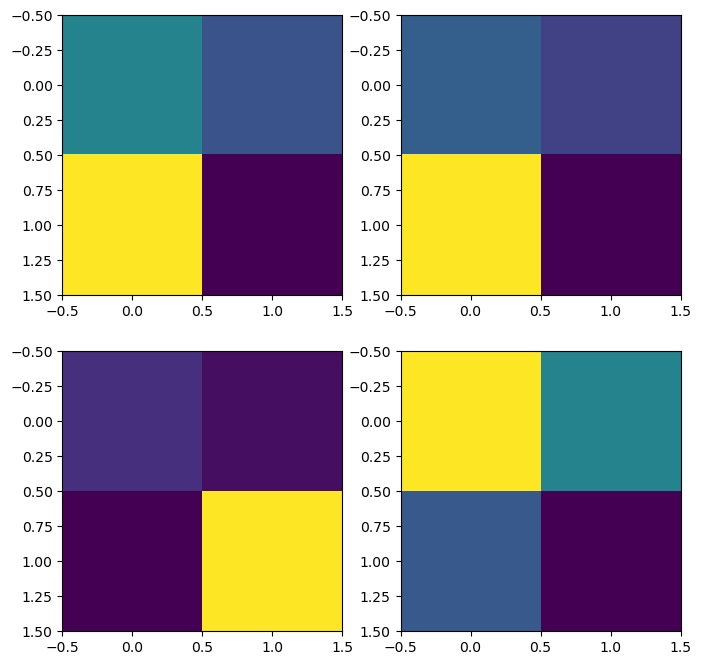

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))

axs[0,0].imshow(jlinops.black_box_to_dense(A1))

axs[0,1].imshow(jlinops.black_box_to_dense(A2))

axs[1,0].imshow(jlinops.black_box_to_dense(A3))

axs[1,1].imshow(jlinops.black_box_to_dense(A4))

plt.show()

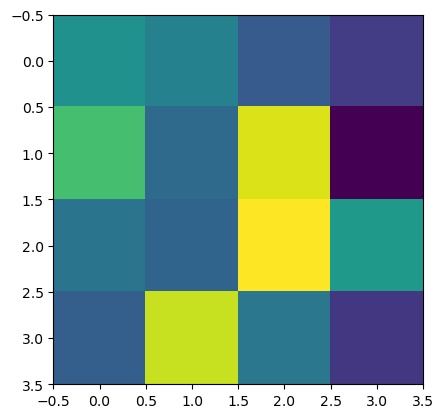

In [11]:
plt.imshow(jlinops.black_box_to_dense(A))
plt.show()

In [ ]:
def block_matrix_operator(A1, A2, A3, A4):
    # Check dimensions for compatibility
    if A1.shape[1] != A3.shape[1] or A2.shape[1] != A4.shape[1] or A1.shape[0] != A2.shape[0] or A3.shape[0] != A4.shape[0]:
        raise ValueError("Block matrices are not compatible")

    # Define the matvec function
    def matvec(x):
        mid = A1.shape[1]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.matvec(x1) + A2.matvec(x2), A3.matvec(x1) + A4.matvec(x2)])

    # Define the rmatvec function
    def rmatvec(x):
        mid = A1.shape[0]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.rmatvec(x1) + A3.rmatvec(x2), A2.rmatvec(x1) + A4.rmatvec(x2)])

    shape = (A1.shape[0] + A3.shape[0], A2.shape[1] + A4.shape[1])
    return LinearOperator(shape, matvec, rmatvec)


# Make operator

In [45]:
class Block2x2Operator(_CustomLinearOperator):
    """Represents a block 2x2 linear operator as
    A = [A1 & A2 // A3 & A4].
    """
    def __init__(self, A1, A2, A3, A4):

        # Check dimensions for compatibility
        if A1.shape[1] != A3.shape[1] or A2.shape[1] != A4.shape[1] or A1.shape[0] != A2.shape[0] or A3.shape[0] != A4.shape[0]:
            raise ValueError("Block matrices are not compatible")
        
        device = get_device(A1) # get device
        xp = device_to_module(device)

        self.A1 = A1
        self.A2 = A2
        self.A3 = A3
        self.A4 = A4

        # Define the matvec function
        def _matvec(x):
            mid = self.A1.shape[1]
            x1, x2 = x[:mid], x[mid:]
            return xp.hstack([self.A1.matvec(x1) + self.A2.matvec(x2), self.A3.matvec(x1) + self.A4.matvec(x2)])

        # Define the rmatvec function
        def _rmatvec(x):
            mid = self.A1.shape[0]
            x1, x2 = x[:mid], x[mid:]
            return xp.hstack([self.A1.rmatvec(x1) + self.A3.rmatvec(x2), self.A2.rmatvec(x1) + self.A4.rmatvec(x2)])

        shape = (self.A1.shape[0] + self.A3.shape[0], self.A1.shape[1] + self.A2.shape[1])

        super().__init__(shape, _matvec, rmatvec=_rmatvec, device=device)


    def to_gpu(self):

        return Block2x2Operator(self.A1.to_gpu(), self.A2.to_gpu(), self.A3.to_gpu(), self.A4.to_gpu())

    def to_cpu(self):

        return Block2x2Operator(self.A1.to_cpu(), self.A2.to_cpu(), self.A3.to_cpu(), self.A4.to_cpu())



In [49]:
A1 = jlinops.MatrixLinearOperator(  np.random.randn( 5, 4 )   )
A2 = jlinops.MatrixLinearOperator(  np.random.randn( 5, 6 )   )
A3 = jlinops.MatrixLinearOperator(  np.random.randn( 3, 4 )   )
A4 = jlinops.MatrixLinearOperator(  np.random.randn( 3, 6 )   )

# A1 = create_dummy_operator_rectangular(2, 3)
# A2 = create_dummy_operator_rectangular(2, 4)
# A3 = create_dummy_operator_rectangular(5, 3)
# A4 = create_dummy_operator_rectangular(5, 4)

In [50]:
# Create the block matrix operator
A = Block2x2Operator(A1, A2, A3, A4)

# Generate random vectors x and y
x = np.random.randn(A.shape[1])
y = np.random.randn(A.shape[0])

# Check the adjoint property
np.testing.assert_almost_equal(np.dot(A.matvec(x), y), np.dot(x, A.rmatvec(y)))


In [51]:
jlinops.check_adjoint(A)

True

In [38]:
def block_matrix_operator_rectangular(A1, A2, A3, A4):
    # Check dimensions for compatibility
    if A1.shape[1] != A3.shape[1] or A2.shape[0] != A1.shape[0] or A4.shape[0] != A3.shape[0] or A2.shape[1] != A4.shape[1]:
        raise ValueError("Block matrices are not compatible for rectangular shapes")

    # Define the matvec function
    def matvec(x):
        mid = A1.shape[1]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.matvec(x1) + A2.matvec(x2), A3.matvec(x1) + A4.matvec(x2)])

    # Define the rmatvec function
    def rmatvec(x):
        mid = A1.shape[0]
        x1, x2 = x[:mid], x[mid:]
        return np.hstack([A1.rmatvec(x1) + A3.rmatvec(x2), A2.rmatvec(x1) + A4.rmatvec(x2)])

    shape = (A1.shape[0] + A3.shape[0], A1.shape[1] + A2.shape[1])
    return LinearOperator(shape, matvec, rmatvec)

# Create dummy LinearOperators with rectangular shapes
def create_dummy_operator_rectangular(rows, cols):
    mat = np.random.randn(rows, cols)
    def matvec(x):
        return mat @ x
    def rmatvec(x):
        return mat.T @ x
    return LinearOperator((rows, cols), matvec, rmatvec)

# Example: Create rectangular LinearOperators
A1 = create_dummy_operator_rectangular(2, 3)
A2 = create_dummy_operator_rectangular(2, 4)
A3 = create_dummy_operator_rectangular(5, 3)
A4 = create_dummy_operator_rectangular(5, 4)

# Create the block matrix operator
A_rect = block_matrix_operator_rectangular(A1, A2, A3, A4)

# Generate random vectors x and y for the adjoint test
x_rect = np.random.randn(A_rect.shape[1])
y_rect = np.random.randn(A_rect.shape[0])

# Perform the adjoint test for rectangular matrices
adjoint_test_result_rect = np.dot(A_rect.matvec(x_rect), y_rect) - np.dot(x_rect, A_rect.rmatvec(y_rect))
adjoint_test_result_rect



8.881784197001252e-16